# テキストマイニング

### ポジネガ分析

In [61]:
import MeCab
import oseti

In [65]:
'''
 トーク履歴テキストのデータフレーム変換
'''
import re
import csv
import datetime
import os
import sys
import pandas as pd
import numpy as np


class Data():
    # flag
    # 0 : talk meassge
    # 10 : call
    # 11 : missed call
    # 12 : canceled call
    # 13 : no answer call
    # 2 : photo
    # 3 : video
    # 4 : sticker
    # 50 : system message unsent
    # 60 : file
    # 70 : create and add album
    # 71 : changed the name of the album
    # 72 : deleted the album
    def __init__(self, year, month, day, hour, minute, person, payload, flag):
        self.year = year
        self.month = month
        self.day = day
        self.hour = hour
        self.minute = minute
        self.person = person
        self.payload = payload
        self.flag = flag


# disable #print
# sys.stdout = open(os.devnull, 'w', encoding="utf-8")

file_path = "line_data/[LINE] りほとのトーク.txt"

date_ = datetime.datetime.now()
logs = []

# open file and load data
with open(file_path, 'r', encoding="utf-8") as f:
    log_text = f.read()

date_pattern = r"20\d{2}/\d{2}/\d{2}"
message_pattern = r"\d{2}:\d{2}\t.*\t.*"
photo_pattern = r"\d{2}:\d{2}\t.*\t\[写真]"
sticker_pattern = r"\d{2}:\d{2}\t.*\t\[スタンプ]"
video_pattern = r"\d{2}:\d{2}\t.*\t\[動画]"
file_pattern = r"\d{2}:\d{2}\t.*\t\[File]"
album_build_pattern = r"\d{2}:\d{2}\t.*\t\[Albums].*"
album_rename_pattern = r"\d{2}:\d{2}\t.* changed the name of the album.*"
album_delete_pattern = r"\d{2}:\d{2}\t.* delete the album.*"
missed_call_pattern = r"\d{2}:\d{2}\t.*\t☎ 不在着信"
canceled_call_pattern = r"\d{2}:\d{2}\t.*\t☎ 通話をキャンセルしました"
no_answer_call_pattern = r"\d{2}:\d{2}\t.*\t☎ 通話に応答がありませんでした"
call_pattern = r"\d{2}:\d{2}\t.*\t☎ 通話時間 (\d{1,2}:\d{2}|\d{1,2}:\d{2}:\d{2})"
sys_unsent_pattern = r"\d{2}:\d{2}\t.* 送信取り消し"

for i, log in enumerate(log_text.splitlines()[3:]):
    #print(f"{log} : ", end='')
    if log == '':
        #print("no data")
        continue
    date_stamp = ""
    if re.match(date_pattern, log):
        #print("day data")
        date_stamp = log.replace('/', ',').replace(' ', ',')[0:10]
        date_ = datetime.datetime.strptime(date_stamp, '%Y,%m,%d')
    elif re.match(photo_pattern, log):
        #print("photo data")
        splited_log = re.split('\t', log)
        logs.append(Data(date_.year, date_.month, date_.day,
                         splited_log[0][0:2], splited_log[0][3:5], splited_log[1], "", 2))
    elif re.match(video_pattern, log):
        #print("Video data")
        splited_log = re.split('\t', log)
        logs.append(Data(date_.year, date_.month, date_.day,
                         splited_log[0][0:2], splited_log[0][3:5], splited_log[1], "", 3))
    elif re.match(sticker_pattern, log):
        #print("Sticker data")
        splited_log = re.split('\t', log)
        logs.append(Data(date_.year, date_.month, date_.day,
                         splited_log[0][0:2], splited_log[0][3:5], splited_log[1], "", 4))
    elif re.match(call_pattern, log):
        #print("call data")
        splited_log = re.split('\t', log)
        time_data = splited_log[2][7:]
        time_data = re.split(':', time_data)
        time_length = 0
        for i in range(len(time_data)):
            time_length += int(time_data[len(time_data) - i - 1]) * (60 ** i)
        # print(time_length)
        logs.append(Data(date_.year, date_.month, date_.day,
                         splited_log[0][0:2], splited_log[0][3:5], splited_log[1], time_length, 10))
    elif re.match(missed_call_pattern, log):
        #print("Missed call data")
        splited_log = re.split('\t', log)
        logs.append(Data(date_.year, date_.month, date_.day,
                         splited_log[0][0:2], splited_log[0][3:5], splited_log[1], "", 11))
    elif re.match(canceled_call_pattern, log):
        #print("Canceled call data")
        splited_log = re.split('\t', log)
        logs.append(Data(date_.year, date_.month, date_.day,
                         splited_log[0][0:2], splited_log[0][3:5], splited_log[1], "", 12))
    elif re.match(no_answer_call_pattern, log):
        #print("no answer call data")
        splited_log = re.split('\t', log)
        logs.append(Data(date_.year, date_.month, date_.day,
                         splited_log[0][0:2], splited_log[0][3:5], splited_log[1], "", 13))
    elif re.match(sys_unsent_pattern, log):
        #print("sys unsent data")
        splited_log = re.split('\t', log)
        logs.append(Data(date_.year, date_.month, date_.day,
                         splited_log[0][0:2], splited_log[0][3:5], "", "", 50))
    elif re.match(file_pattern, log):
        #print("file data")
        splited_log = re.split('\t', log)
        logs.append(Data(date_.year, date_.month, date_.day,
                         splited_log[0][0:2], splited_log[0][3:5], "", "", 60))
    elif re.match(album_build_pattern, log):
        #print("create album data")
        splited_log = re.split('\t', log)
        logs.append(Data(date_.year, date_.month, date_.day,
                         splited_log[0][0:2], splited_log[0][3:5], "", "", 70))
    elif re.match(album_rename_pattern, log):
        #print("rename album data")
        splited_log = re.split('\t', log)
        logs.append(Data(date_.year, date_.month, date_.day,
                         splited_log[0][0:2], splited_log[0][3:5], "", "",71))
    elif re.match(album_delete_pattern, log):
        #print("delete album data")
        splited_log = re.split('\t', log)
        logs.append(Data(date_.year, date_.month, date_.day,
                         splited_log[0][0:2], splited_log[0][3:5], "", "", 72))
    elif re.match(message_pattern, log):
        #print("message data")
        splited_log = re.split('\t', log)
        logs.append(Data(date_.year, date_.month, date_.day,
                         splited_log[0][0:2], splited_log[0][3:5], splited_log[1], splited_log[2], 0))
    elif (len(re.split('\t', log)) == 1):
        splited_log = re.split('\t', log)
        #print("returned data")
        if len(logs)!=0:
            logs[-1].payload += log
    else:
        pass
        #print("\nNo classified data\n")

with open('tempo_data/line.csv', 'w', encoding="utf-8", newline="") as f:
    for content in logs:
        writer = csv.writer(f)
        writer.writerow([str(content.year), str(content.month), str(content.day), str(content.hour),str(content.minute), str(content.person), str(content.payload), str(content.flag)])

print("Success🎉")

"""
 データフレームに格納
"""
df = pd.read_csv("tempo_data/line.csv", names=('year', 'month', 'day',
                                   'hour', 'minute', 'person', 'payloads', 'flag'), encoding="UTF-8")


Success🎉


In [66]:
###-----------------------------------------------------------------------
### ポジネガ判定
###-----------------------------------------------------------------------
analyzer = oseti.Analyzer()
#コメントごとにポジネガ判定
df["posi_nega"] = df["payloads"].apply(lambda x: analyzer.analyze(str(x)))
df["posi_nega"] = df["posi_nega"].apply(lambda x: sum(x))

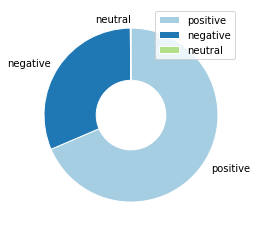

In [67]:
###-----------------------------------------------------------------------
### スコア計算の諸々の処理
###-----------------------------------------------------------------------
#ポジネガスコアでグループ化
df_groupby_posinega =  df.groupby('posi_nega').count()
#インデックスの処理
df_groupby_posinega = df_groupby_posinega.reset_index()
#重み付けしたポジネガスコアの算出
df_groupby_posinega['score'] = 0
df_groupby_posinega['score'] = df_groupby_posinega.apply(lambda x: x['year'] * x['posi_nega'], axis = 1)
#スコアを格納するデータフレームdf_posinegaの作成
df_posinega = pd.DataFrame(np.arange(3).reshape(1, 3),
                          columns = ["positive", "negative", "neutral"],
                          index = ["score"])

df_posinega["positive"] = df_groupby_posinega["score"].where(df_groupby_posinega["score"] > 0).sum()
df_posinega["negative"] = -(df_groupby_posinega["score"].where(df_groupby_posinega["score"] < 0).sum())
df_posinega["neutral"] = df_groupby_posinega["score"].where(df_groupby_posinega["score"] == 0).count()



###-----------------------------------------------------------------------
### グラフの作成
###-----------------------------------------------------------------------
import matplotlib.pyplot as plt
%matplotlib inline

x = [df_posinega["positive"].item(), df_posinega["negative"].item(), df_posinega["neutral"].item()]
labels = ["positive", "negative", "neutral"]#円グラフ用ラベル

cmap = plt.get_cmap("Paired")
colors = [cmap(i) for i in range(len(x))]

wedgeprops={"edgecolor":"white", "width":0.6}

fig, ax = plt.subplots()
ax.pie(x, labels=labels,
      startangle=90,
      counterclock = False,
      colors = colors,
      wedgeprops = wedgeprops)
plt.legend()
plt.show()

In [68]:
###-------------------------------------------------------
### ネガティブ文章の抜き出し
###-------------------------------------------------------
df_negative = df[df['posi_nega'] < 0]
df_negative.groupby("person").count()
###気になる属性でグループバイをしていけばいいよね


,year,month,day,hour,minute,payloads,flag,posi_nega
person,,,,,,,,
りほ,121,121,121,121,121,121,121,121
友利優希,133,133,133,133,133,133,133,133


### ワードクラウド

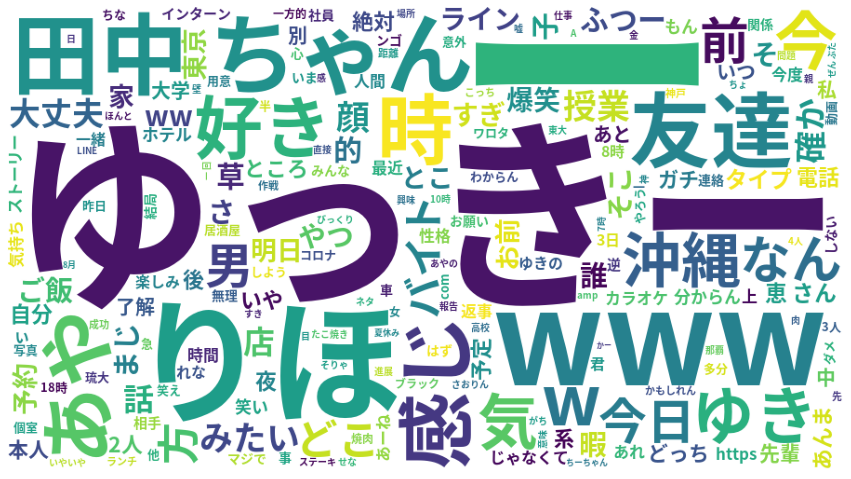

In [73]:
###---------------------------------------------------------------
### 必要なライブラリのインポート
###---------------------------------------------------------------
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import MeCab
import pandas as pd
import numpy as np

###---------------------------------------------------------------
###  コメントのみを文章として抽出
###---------------------------------------------------------------
df = pd.read_csv("tempo_data/line.csv", names=('year', 'month', 'day',
                                   'hour', 'minute', 'person', 'payloads', 'flag'), encoding="UTF-8")
df_comment = df["payloads"]
df_comment.to_csv("tempo_data/LINEトーク抽出.csv",
                  header=None,
                  index=False,
                  encoding="UTF-8")


text_file = open("tempo_data/LINEトーク抽出.csv")
full_text = text_file.read()
full_text= full_text.replace("\n","")

#print(full_text)  

###--------------------------------------------------------------
### MeCabで形態素解析
###--------------------------------------------------------------

fpath = '/Users/tomoriyuuki/Library/Fonts/NotoSansCJKjp-Bold.otf'  # 日本語フォント指定
stop_words_ja = ['もの', 'こと', 'とき', 'そう', 'たち', 'これ', 'よう', 'これら', 'それ', 'すべて', '笑笑', '笑', '何', 'の', 'ん', '人']#省きたい言葉
tagger = MeCab.Tagger("-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd")
#tagger = MeCab.Tagger()
tagger.parse('')
node = tagger.parseToNode(full_text)

word_list = []
while node:
        word_type = node.feature.split(',')[0]
        word_surf = node.surface.split(',')[0]
        if word_type == '名詞' and word_surf not in stop_words_ja:
            word_list.append(node.surface)
        node = node.next

word_chain = ' '.join(word_list)
wordcloud = WordCloud(background_color="white",
                          font_path=fpath,
                          width=900,
                          height=500,
                          contour_width=1,
                          contour_color="black",
                          stopwords=set(stop_words_ja)).generate(word_chain)

#描画
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
#png出力
wordcloud.to_file("img_data/wc_image.png")

### 好きな形にワードクラウド

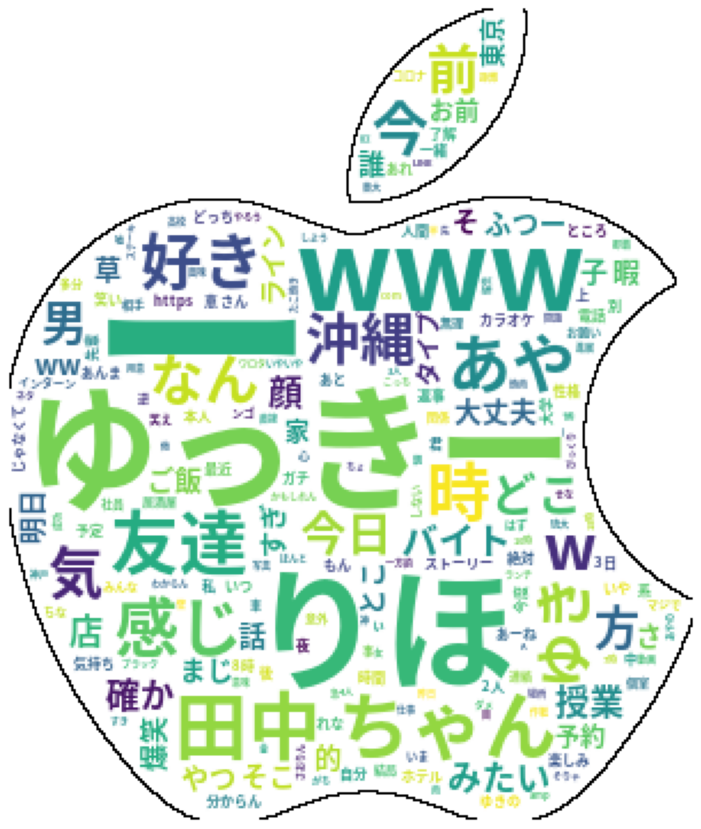

In [74]:
def get_mask(img_path):
    import cv2
    img = cv2.imread(img_path, -1)
    a_img = img[:, :, 3]
    result_img = cv2.bitwise_not(a_img)
 
    return result_img

fpath = '/Users/tomoriyuuki/Library/Fonts/NotoSansCJKjp-Bold.otf'  # 日本語フォント指定
stop_words_ja =  ['もの', 'こと', 'とき', 'そう', 'たち', 'これ', 'よう', 'これら', 'それ', 'すべて', '笑笑', '笑', '何', 'の', 'ん', '人']#省きたい言葉
tagger = MeCab.Tagger("-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd")
tagger.parse('')
node = tagger.parseToNode(full_text)
#mask取得
mask = get_mask("mask_data/apple.png")
word_list = []
while node:
        word_type = node.feature.split(',')[0]
        word_surf = node.surface.split(',')[0]
        if word_type == '名詞' and word_surf not in stop_words_ja:
            word_list.append(node.surface)
        node = node.next

word_chain = ' '.join(word_list)
wordcloud = WordCloud(background_color="White",
                          font_path=fpath,
                          contour_width=1,
                          mask = mask,
                          max_font_size = 100,
                          max_words = 1000,
                          #mode = "RGBA",
                          #colormap="hsv",
                          stopwords=set(stop_words_ja)).generate(word_chain)

#描画
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()
#png出力
wordcloud.to_file("img_data/wc_mask_image.png")